# 1 Predicting Gender of Brazilian Names Using Deep Learning

## 1.1 Necessary libraries

In [1]:
import pandas as pd                       
import numpy as np
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Flatten, TimeDistributed
from keras.layers import Dense, LSTM, Bidirectional, Activation
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## 1.2 Read the dataset

In [2]:
import requests
url = "https://data.brasil.io/dataset/genero-nomes/nomes.csv.gz"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

df = pd.read_csv('nomes.csv.gz') 
df.head()

,alternative_names,classification,first_name,frequency_female,frequency_male,frequency_total,frequency_group,group_name,ratio
0,AILINE|ALEINE|ALIINE|ALINE|ALINER|ALINHE|ALINN...,F,AALINE,66.0,NaN,66,530550,ALINE,1.0
1,ARAAO|ARAO,M,AARAO,NaN,281.0,281,3526,ARAO,1.0
2,AHARON|AROM|ARON|ARYON|HARON,M,AARON,NaN,676.0,676,3442,ARON,1.0
3,ADA|ADAH|ADAR|ADHA|HADA,F,ABA,82.0,NaN,82,5583,ADA,1.0
4,NaN,M,ABADE,NaN,57.0,57,57,ABADE,1.0


### 1.2.1 Preparing the data

In [3]:
y = df['classification'].astype("category").cat.codes.values    # y labels into numbers 0 is F and 1 is M
names = df['first_name'].apply(lambda x: x.lower())             # input names

In [4]:
print("M : " + str(sum(y==1)))
print("F : " + str(sum(y==0)))
print(len(y))

M : 45537
F : 55250
100787


## 1.3 Encoding Words

In [5]:
#word encoding
maxlen = 20                                               # max lenght of a name

'''Define a vocabulary which corresponds to all the unique letters encountered'''
vocab = set(' '.join([str(i) for i in names]))            # creating a vocab
vocab.add('END')
len_vocab = len(vocab)

char_index = dict((c, i) for i, c in enumerate(vocab))    # creating a dictionary
''' The dictionary maps each letter of vocabulary to a number '''

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    aux = np.zeros(len_vocab);
    aux[i] = 1
    return list(aux)

# Truncate names and create the matrix
def prepare_encod_names(X):
    vec_names = []
    trunc_name = [str(i)[0:maxlen] for i in X]  # consider only the first 20 characters
    for i in trunc_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        vec_names.append(tmp)
    return vec_names

'''This is called one-hot-encoder and is based on the following papers: 
https://arxiv.org/abs/1707.07129 : Predicting the gender of Indonesian names
https://ieeexplore.ieee.org/document/8560790 : Advance Gender Prediction Tool...
 '''

'This is called one-hot-encoder and is based on the following papers: \nhttps://arxiv.org/abs/1707.07129 : Predicting the gender of Indonesian names\nhttps://ieeexplore.ieee.org/document/8560790 : Advance Gender Prediction Tool...\n '

In [6]:
x = prepare_encod_names(names.values)   # Now the names are encod as a vector of numbers

## 1.4 Split the data into test and train

In [7]:
# train, val, test set will be 20%, 60%, 20% of the dataset respectively
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=28)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=40)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

## 1.5 Building the BiLSTM Model

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)]

In [8]:
LSTMmodel = keras.Sequential()
LSTMmodel = keras.Sequential()
LSTMmodel.add(Bidirectional(LSTM(64, return_sequences=True), backward_layer=LSTM(64, return_sequences=True, go_backwards=True), input_shape=(maxlen,len_vocab)))
LSTMmodel.add(Dropout(0.1))
LSTMmodel.add(Bidirectional(LSTM(64)))
#LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Dense(1, activity_regularizer=l2(0.002)))
LSTMmodel.add(Activation('sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)
LSTMmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

LSTMhistory = LSTMmodel.fit(x_train, y_train, batch_size=256, epochs=50, validation_data=(x_val, y_val), callbacks=callbacks)
LSTMscores = LSTMmodel.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (LSTMscores[1]*100))

Epoch 1/50
237/237 [==============================] - 51s 192ms/step - loss: 0.3774 - accuracy: 0.8280 - val_loss: 0.2394 - val_accuracy: 0.9132
Epoch 2/50
237/237 [==============================] - 47s 197ms/step - loss: 0.2438 - accuracy: 0.9107 - val_loss: 0.2100 - val_accuracy: 0.9279
Epoch 3/50
237/237 [==============================] - 47s 198ms/step - loss: 0.2184 - accuracy: 0.9233 - val_loss: 0.2104 - val_accuracy: 0.9259
Epoch 4/50
237/237 [==============================] - 47s 199ms/step - loss: 0.2014 - accuracy: 0.9313 - val_loss: 0.1871 - val_accuracy: 0.9424
Epoch 5/50
237/237 [==============================] - 47s 197ms/step - loss: 0.1908 - accuracy: 0.9371 - val_loss: 0.1742 - val_accuracy: 0.9457
Epoch 6/50
237/237 [==============================] - 47s 197ms/step - loss: 0.1812 - accuracy: 0.9420 - val_loss: 0.1783 - val_accuracy: 0.9422
Epoch 7/50
237/237 [==============================] - 47s 198ms/step - loss: 0.1749 - accuracy: 0.9453 - val_loss: 0.1638 - val_ac

## 1.6 Figures

<Figure size 432x288 with 0 Axes>

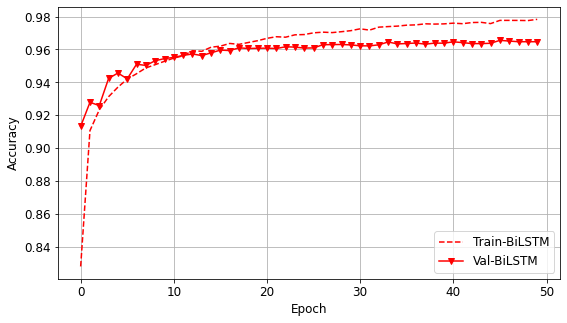

In [9]:
plt.figure(1)
plt.figure(figsize=(9,5))
plt.rcParams.update({'font.size':12})
plt.plot(LSTMhistory.history['accuracy'], '--', color="#3498DB")
plt.plot(LSTMhistory.history['val_accuracy'], '-v', color="#D35400")
plt.grid('True')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento-BiLSTM', 'Validação-BiLSTM'], loc='lower right')
fig = plt.gcf()
fig.savefig(r'Model/BiLSTM_Accuracy.eps', format='eps', dpi=1200)

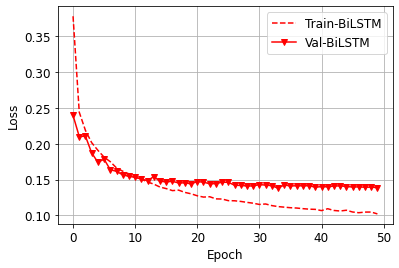

In [10]:
plt.figure(2)
plt.plot(LSTMhistory.history['loss'], '--', color="#3498DB")
plt.plot(LSTMhistory.history['val_loss'], '-v', color="#D35400")
plt.ylabel('Perdas')
plt.xlabel('Épocas')
plt.legend(['Treinamento-BiLSTM', 'Validação-BiLSTM'], loc='upper right')
plt.grid('True')
fig = plt.gcf()
fig.savefig(r'Model/BiLSTM_loss.eps', format='eps', dpi=1200)

## 1.7 Statistics

In [11]:
y_pred = (LSTMmodel.predict(x_test)>0.5).astype("int32")

In [12]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("precision {0:.4f} recall {1:.4f}".format(precision, recall))

precision 0.9618 recall 0.9612


In [ ]:
print(f"F1-Score: {2*((precision*recall)/(precision+recall))}")

In [13]:
LSTMmodel.save(r"./Model/BiLSTM.hdf5")